<a href="https://colab.research.google.com/github/LenaGeller/retail_demand_analysis/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import requests
import io

# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"])) we dont read it as the file is too big and wont work this way
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


In [2]:
import gdown

# Use our existing function to build the download URL
train_url = make_drive_url(file_ids["train"])

# Download the file using gdown
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=44205705-d992-4d00-b4de-b74c3a9d2927
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:56<00:00, 89.0MB/s]


'train.csv'

In [3]:
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
import pandas as pd

chunk_size = 10**6  # 1 million rows at a time
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk  # Free up memory
df_train = pd.concat(filtered_chunks, ignore_index=True)
df_train = df_train.sample(n=2_000_000).reset_index(drop=True)
del filtered_chunks
# Loads first 5 rows
df_train.head(5)

/tmp/ipython-input-4212995332.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,97871318,2016-11-24,29,554049,1.000,False
1,7997314,2013-07-07,35,457928,6.163,NaN
2,45720495,2015-04-29,29,213066,5.000,False
3,40924204,2015-02-10,30,1121515,3.000,False
4,37063236,2014-12-10,30,1333224,3.000,False


In [4]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [5]:
# 1. Top-3-Familien bestimmen
family_counts = df_items.groupby("family")["item_nbr"].nunique().sort_values(ascending=False)
top3_families = family_counts.head(3).index
print("Top 3 Familien:", top3_families)

# 2. Items dieser Familien herausholen
top3_items = df_items[df_items["family"].isin(top3_families)]["item_nbr"]

# 3. df_train auf diese Items beschränken
df_train_3 = df_train[df_train["item_nbr"].isin(top3_items)]
df_train_3.head()


Top 3 Familien: Index(['GROCERY I', 'BEVERAGES', 'CLEANING'], dtype='object', name='family')


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,97871318,2016-11-24,29,554049,1.0,False
2,45720495,2015-04-29,29,213066,5.0,False
3,40924204,2015-02-10,30,1121515,3.0,False
4,37063236,2014-12-10,30,1333224,3.0,False
6,36624208,2014-12-04,30,828204,5.0,False


In [6]:
# 1.  Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2.  Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Time Series/df_train_3.pkl" # example of path

# 3.  SAVE the cleaned DataFrame
df_train_3.to_pickle(save_path)
print(f"Saved to: {save_path}")

Mounted at /content/drive
Saved to: /content/drive/MyDrive/Time Series/df_train_3.pkl


In [3]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')                # re-mount
load_path = "/content/drive/MyDrive/Time Series/df_train_3.pkl" #example of path, use the same as above
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")


Mounted at /content/drive
DataFrame reloaded, ready to go!


# Data Quality Checks

In [4]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,240370


In [5]:
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

/tmp/ipython-input-3519284033.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


In [6]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


In [7]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
5710,124718541,2017-08-08,24,1965074,-6.0,False
83160,90825636,2016-09-12,51,468265,-2.0,False
89451,80926770,2016-06-01,51,268623,-1.0,False
120237,112526522,2017-04-15,24,2011910,-8.0,False
156534,53378211,2015-08-07,51,1000866,-1.0,False


In [8]:
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [9]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score for unit_sales (avoiding division by zero for standard deviation), and store it in a new column called z_score
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group, then flatten the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 3531


/tmp/ipython-input-1326790782.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
239,76849626,2016-04-20,24,105574,110.0,False,9.243621
742,63823080,2015-12-03,24,105857,116.0,False,9.514204
948,47159290,2015-05-21,24,108079,17.0,False,5.942972
1468,13913624,2013-11-13,24,111223,109.0,False,10.755643
1910,95892808,2016-11-04,24,114790,34.0,True,7.909749


In [10]:
outliers_with_holidays = outliers.merge(
    df_holiday_events[['date', 'type', 'description']],
    on='date',
    how='left'
)

# Check: welche Outlier fallen auf Feiertage? + Produkt + Store
outliers_with_holidays[['date', 'store_nbr', 'item_nbr',
                        'unit_sales', 'onpromotion', 'type', 'description']].head(20)

,date,store_nbr,item_nbr,unit_sales,onpromotion,type,description
0,2016-04-20,24,105574,110.0,False,Event,Terremoto Manabi+4
1,2015-12-03,24,105857,116.0,False,NaN,NaN
2,2015-05-21,24,108079,17.0,False,NaN,NaN
3,2013-11-13,24,111223,109.0,False,NaN,NaN
4,2016-11-04,24,114790,34.0,True,Bridge,Puente Dia de Difuntos
5,2015-12-18,24,115720,20.0,False,NaN,NaN
6,2016-04-19,24,116017,110.0,False,Event,Terremoto Manabi+3
7,2015-01-19,24,119026,94.0,False,NaN,NaN
8,2016-04-18,24,119187,50.0,False,Event,Terremoto Manabi+2
9,2013-12-20,24,119624,51.0,False,NaN,NaN


In [11]:
unexplained_outliers = outliers_with_holidays[
    (outliers_with_holidays['onpromotion'] == False) &
    (outliers_with_holidays['type'].isna())
]

# mal anschauen
unexplained_outliers[['date', 'store_nbr', 'item_nbr', 'unit_sales']].head(20)


,date,store_nbr,item_nbr,unit_sales
1,2015-12-03,24,105857,116.0
2,2015-05-21,24,108079,17.0
3,2013-11-13,24,111223,109.0
5,2015-12-18,24,115720,20.0
7,2015-01-19,24,119026,94.0
9,2013-12-20,24,119624,51.0
10,2015-06-28,24,122425,10.0
14,2014-12-07,24,129296,13.0
20,2013-06-01,24,155610,14.0
22,2015-05-27,24,155625,12.0


In [12]:
len(unexplained_outliers)

1697

In [13]:
unexplained_outliers['item_nbr'].value_counts().head(10)


,count
item_nbr,
1084437,7
956013,7
850333,7
1137146,7
168989,6
262991,6
1047786,6
1057033,6
1158720,6


In [14]:

cap_values = df_train.groupby('item_nbr')['unit_sales'].quantile(0.99)

# 2. Funktion zum Capping definieren
def cap_outliers(row):
    if row.name in unexplained_outliers.index:  # nur auf unexplained anwenden
        cap = cap_values[row['item_nbr']]
        return min(row['unit_sales'], cap)
    else:
        return row['unit_sales']

# 3. Neue Spalte mit gekappten Werten
df_train['unit_sales_capped'] = df_train.apply(cap_outliers, axis=1)


capped_count = (df_train['unit_sales'] != df_train['unit_sales_capped']).sum()
print(f"Anzahl gekappter Outlier: {capped_count}")

# 5. Optional: ein paar Beispiele zeigen
df_train.loc[df_train['unit_sales'] != df_train['unit_sales_capped'],
             ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'unit_sales_capped']].head(10)

Anzahl gekappter Outlier: 10


,date,store_nbr,item_nbr,unit_sales,unit_sales_capped
708,2016-12-04,28,1325324,28.0,20.96
1118,2016-04-17,27,111397,54.0,52.00
1182,2017-03-16,51,360705,25.0,24.97
1879,2013-09-28,51,1157561,31.0,29.95
1939,2013-07-12,28,953609,25.0,10.00
2571,2013-05-29,36,411555,14.0,12.00
2606,2016-04-22,32,158788,32.0,20.72
2788,2017-08-02,51,1464072,7.0,6.00
3082,2016-04-20,29,1167544,44.0,41.50
3292,2017-05-01,28,123602,17.0,16.46


# Fill Calender

In [15]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [16]:
def fill_calendar(group):
    #
    # group contains all rows for ONE (store_nbr, item_nbr) pair
    #
    g = group.set_index("date").sort_index()          # use date/calendar as the index
    g = g.asfreq("D", fill_value=0)                   # make it daily; add 0 where missing

    # put the identifiers back (asfreq drops them)
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    return g.reset_index()                            # date back to a normal column


In [17]:
df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)
df_train.head()

/tmp/ipython-input-32987793.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped
0,2013-01-25,944616,24,96995,2.0,False,2.0
1,2013-01-26,0,24,96995,0.0,0,0.0
2,2013-01-27,0,24,96995,0.0,0,0.0
3,2013-01-28,0,24,96995,0.0,0,0.0
4,2013-01-29,0,24,96995,0.0,0,0.0


# Date Transformation

In [18]:
# Make sure 'date' is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Split the timestamp into model-friendly parts
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek # Monday=0 … Sunday=6

# Lets check the result
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week
0,2013-01-25,944616,24,96995,2.0,False,2.0,2013,1,25,4
1,2013-01-26,0,24,96995,0.0,0,0.0,2013,1,26,5
2,2013-01-27,0,24,96995,0.0,0,0.0,2013,1,27,6
3,2013-01-28,0,24,96995,0.0,0,0.0,2013,1,28,0
4,2013-01-29,0,24,96995,0.0,0,0.0,2013,1,29,1


# Moving Means and Medians

In [19]:
# 7-day rolling average of unit_sales, per (item, store)
df_train = df_train.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True) # make sure rows are in time order

df_train["unit_sales_7d_avg"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales_capped"]      # isolate one time-series per (item, store), get the units sold
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())       #  mean of last 7 days, i.e. 7-day moving average, aligned back to original df
)

In [20]:
# Lets see how the new column unit_sales_7d_avg looks like. For that, we'll need to select a store and item.
# Get store and item from the first row
store_id = df_train.iloc[0]['store_nbr']
item_id = df_train.iloc[0]['item_nbr']

# Filter the DataFrame for this store-item pair
sample = df_train[(df_train['store_nbr'] == store_id) & (df_train['item_nbr'] == item_id)]
sample.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-25,944616,24,96995,2.0,False,2.0,2013,1,25,4,2.000000
1,2013-01-26,0,24,96995,0.0,0,0.0,2013,1,26,5,1.000000
2,2013-01-27,0,24,96995,0.0,0,0.0,2013,1,27,6,0.666667
3,2013-01-28,0,24,96995,0.0,0,0.0,2013,1,28,0,0.500000
4,2013-01-29,0,24,96995,0.0,0,0.0,2013,1,29,1,0.400000


In [21]:
# 1.  Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2.  Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Time Series/df_train_4.pkl" # example of path

# 3.  SAVE the cleaned DataFrame
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to: /content/drive/MyDrive/Time Series/df_train_4.pkl


In [2]:
from google.colab import drive
drive.mount('/content/drive')                # re-mount
load_path = "/content/drive/MyDrive/Time Series/df_train_4.pkl" #example of path, use the same as above
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")


Mounted at /content/drive
DataFrame reloaded, ready to go!


# Vizualizatoins

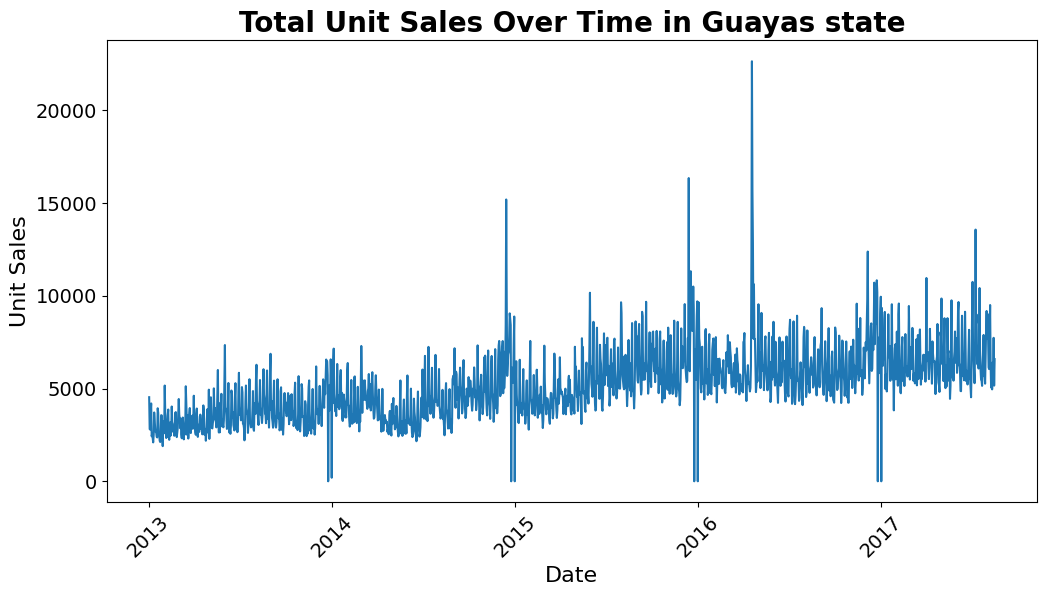

In [3]:
import matplotlib.pyplot as plt

# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales_capped'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [4]:
spikes = df_train[(df_train['date'] >= '2016-01-01') & (df_train['date'] <= '2016-06-30')]
spikes.sort_values(by='unit_sales', ascending=False).head(10)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week,unit_sales_7d_avg
2302862,2016-04-18,76655601,24,257847,6909.0,False,6909.0,2016,4,18,0,1007.142857
2302863,2016-04-19,76753186,24,257847,2281.0,False,2281.0,2016,4,19,1,1333.000000
21070630,2016-05-11,78886109,36,1962621,979.0,False,979.0,2016,5,11,2,172.285714
9557460,2016-05-08,78598352,34,819932,728.0,False,728.0,2016,5,8,6,148.142857
2318164,2016-04-17,76609291,51,257847,644.0,False,644.0,2016,4,17,6,125.142857
16468896,2016-06-21,82767306,24,1224521,589.0,False,589.0,2016,6,21,1,95.571429
18327757,2016-04-25,77381310,51,1430040,567.0,False,567.0,2016,4,25,0,81.000000
8386572,2016-04-20,76857234,28,716250,527.0,False,527.0,2016,4,20,2,75.285714
11099612,2016-04-20,76859202,29,907686,510.0,False,510.0,2016,4,20,2,91.000000
9557365,2016-02-03,69532866,34,819932,493.0,False,493.0,2016,2,3,2,139.571429


We observe an extreme sales spike across multiple stores in mid-to-late April 2016, peaking around April 18–19. This timing coincides with the major earthquake in Ecuador on April 16, 2016, which likely triggered panic buying and stockpiling of essential goods. Therefore, the spike is best explained by this external shock rather than regular market dynamics.

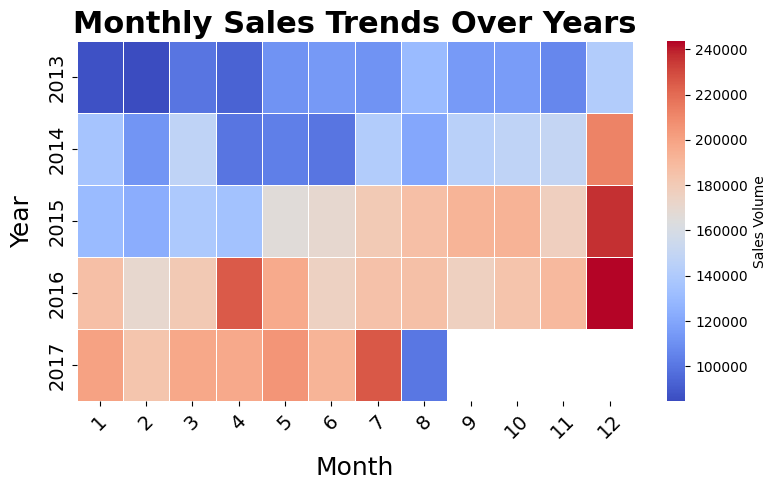

In [5]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales_capped'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

# Holidays Trends

In [10]:
# Convert date column to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


In [11]:
df_train_holiday = pd.merge(
    df_train,                     # daily sales
    df_holiday_events[['date', 'type']],  # keep only what we need
    on='date',
    how='left'                    # non-holiday days get NaN in 'type'
)
df_train_holiday.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week,unit_sales_7d_avg,type
0,2013-01-25,944616,24,96995,2.0,False,2.0,2013,1,25,4,2.000000,NaN
1,2013-01-26,0,24,96995,0.0,0,0.0,2013,1,26,5,1.000000,NaN
2,2013-01-27,0,24,96995,0.0,0,0.0,2013,1,27,6,0.666667,NaN
3,2013-01-28,0,24,96995,0.0,0,0.0,2013,1,28,0,0.500000,NaN
4,2013-01-29,0,24,96995,0.0,0,0.0,2013,1,29,1,0.400000,NaN


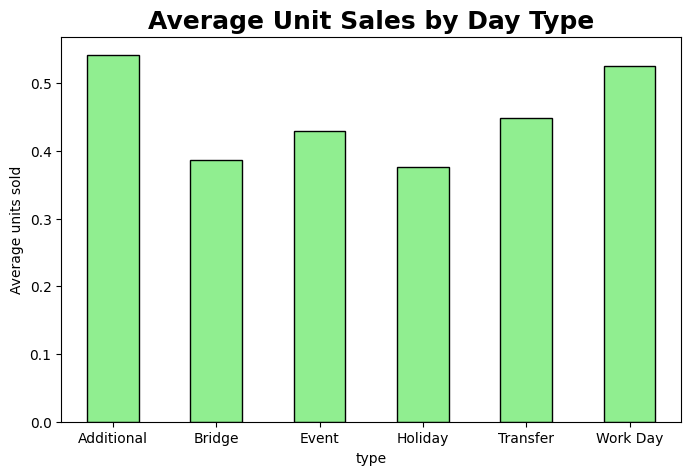

In [12]:
# 4. Compare average sales for each holiday type
# 1–2  average units sold for each day-type
holiday_sales = df_train_holiday.groupby('type')['unit_sales_capped'].mean()

# 3  bar chart
holiday_sales.plot(kind='bar', figsize=(8,5), color='lightgreen', edgecolor='black')
plt.title('Average Unit Sales by Day Type', fontsize=18, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

# Perishable Items

In [13]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [30]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
df_train_items.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week,unit_sales_7d_avg,family,class,perishable
0,2013-01-25,944616,24,96995,2.0,False,2.0,2013,1,25,4,2.000000,GROCERY I,1093,False
1,2013-01-26,0,24,96995,0.0,0,0.0,2013,1,26,5,1.000000,GROCERY I,1093,False
2,2013-01-27,0,24,96995,0.0,0,0.0,2013,1,27,6,0.666667,GROCERY I,1093,False
3,2013-01-28,0,24,96995,0.0,0,0.0,2013,1,28,0,0.500000,GROCERY I,1093,False
4,2013-01-29,0,24,96995,0.0,0,0.0,2013,1,29,1,0.400000,GROCERY I,1093,False


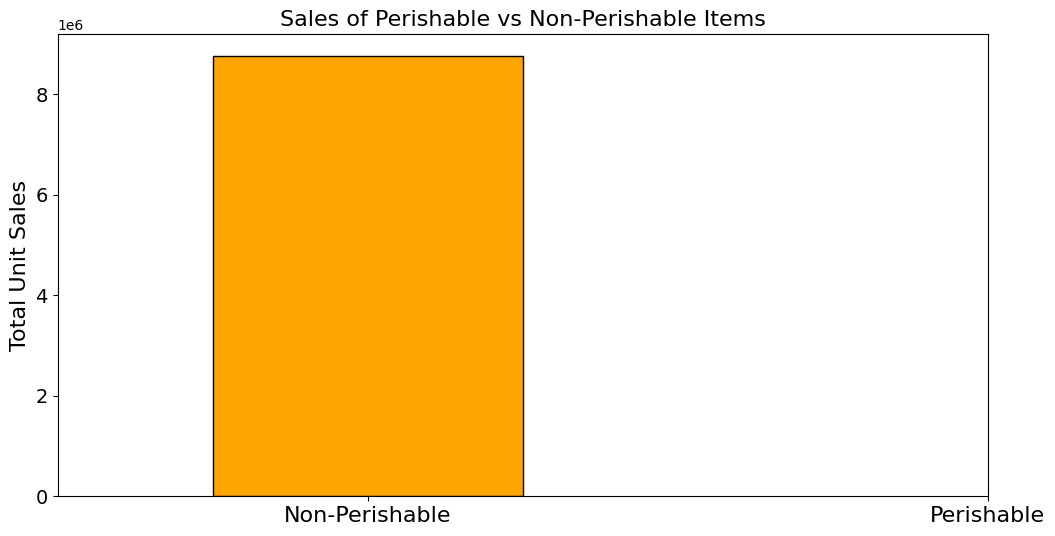

In [31]:
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales_capped'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

# Oil-prices

In [32]:
df_oil['date'] = pd.to_datetime(df_oil['date'])

df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil = (df_oil
          .set_index('date')
          .asfreq('D')              # lückenloser Tageskalender
          .ffill()                  # Wochenenden/Feiertage vorwärts füllen
          .rename_axis('date')
          .reset_index())
df_oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
5,2013-01-06,93.12
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


In [33]:
daily_sales = (df_train
               .groupby('date')['unit_sales_capped']
               .sum()
               .reset_index())


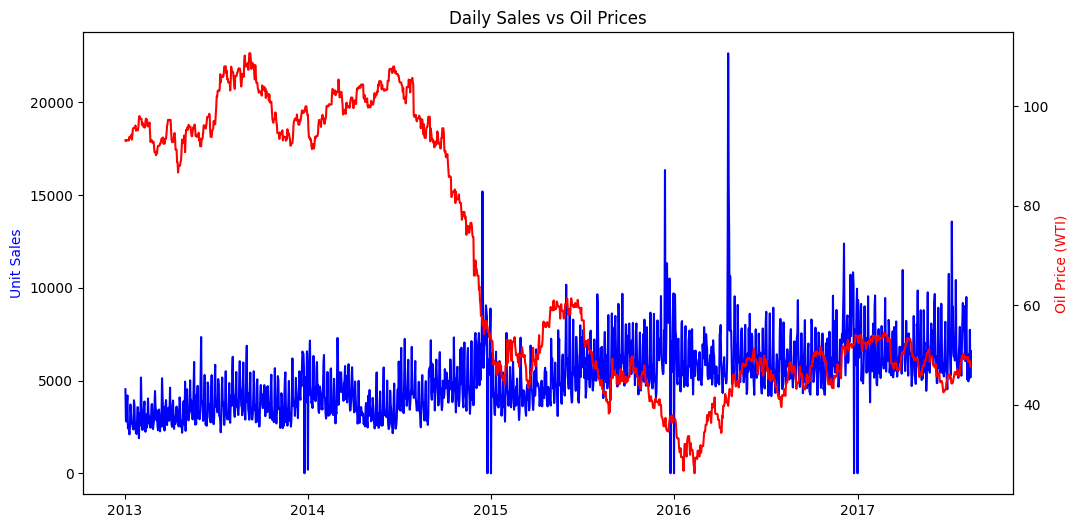

In [34]:
sales_oil = daily_sales.merge(df_oil[['date','dcoilwtico']], on='date', how='left')
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(sales_oil['date'], sales_oil['unit_sales_capped'], color='blue', label='Daily Sales')
ax1.set_ylabel('Unit Sales', color='blue')

ax2 = ax1.twinx()
ax2.plot(sales_oil['date'], sales_oil['dcoilwtico'], color='red', label='Oil Price')
ax2.set_ylabel('Oil Price (WTI)', color='red')

plt.title("Daily Sales vs Oil Prices")
plt.show()



In [35]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


# Autokorrellation

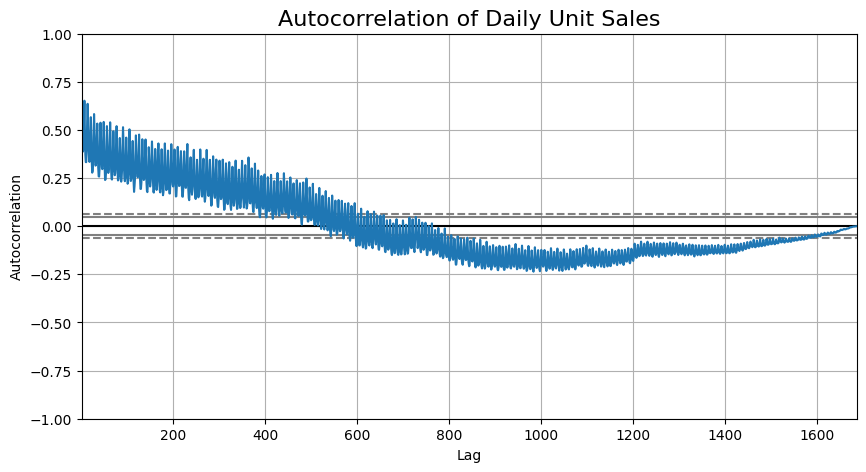

In [14]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()


# Test for Stationarity

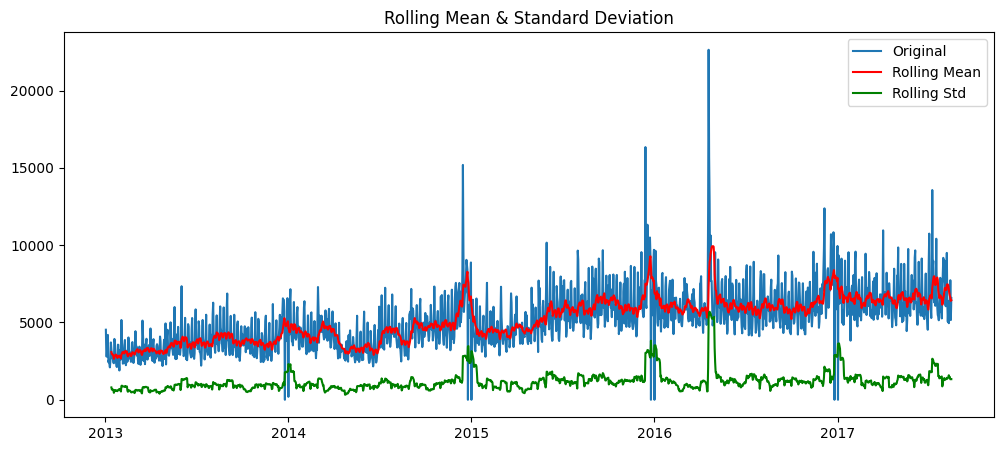

In [37]:
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [38]:
!pip install statsmodels

In [39]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_date)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.0964639351147896
p-value: 0.026815982243673358


# Decomposition




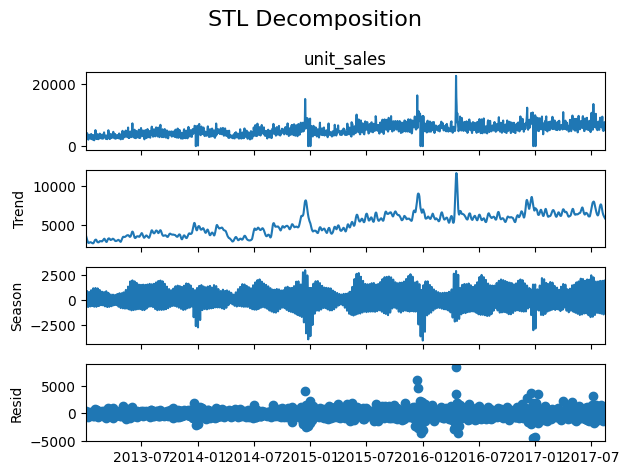

In [40]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(sales_by_date, period=7)  # again, adjust period based on your seasonality
res = stl.fit()

# Plot STL decomposition
res.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

In [42]:
# Calculate strength of trend and seasonality
# Based on Hyndman’s definition: Strength = 1 - (variance of remainder / variance of (component + remainder))

import numpy as np

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of Trend: {trend_strength:.2f}")
print(f"Strength of Seasonality: {seasonal_strength:.2f}")

Strength of Trend: 0.81
Strength of Seasonality: 0.66


# Saisonalität prüfen

In [41]:
from statsmodels.tsa.stattools import adfuller
y = sales_by_date.asfreq('D')
print("ADF raw:", adfuller(y)[1])                # ~0.027  → d=0
print("ADF seasonal diff(7):", adfuller(y.diff(7).dropna())[1])  # <0.05 → D=1


ADF raw: 0.026815982243673358
ADF seasonal diff(7): 9.895503897625954e-22


# Zusammenführen

In [15]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_capped,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-25,944616,24,96995,2.0,False,2.0,2013,1,25,4,2.000000
1,2013-01-26,0,24,96995,0.0,0,0.0,2013,1,26,5,1.000000
2,2013-01-27,0,24,96995,0.0,0,0.0,2013,1,27,6,0.666667
3,2013-01-28,0,24,96995,0.0,0,0.0,2013,1,28,0,0.500000
4,2013-01-29,0,24,96995,0.0,0,0.0,2013,1,29,1,0.400000


In [16]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [17]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [18]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [20]:
import pandas as pd

# Datumsfelder
df_train['date']          = pd.to_datetime(df_train['date'])
df_transactions['date']   = pd.to_datetime(df_transactions['date'])
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

# onpromotion NaN -> False (für exogene Features später wichtig)
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

print("train:", df_train.shape)
print(df_train.head(3))


train: (22287800, 12)
        date      id  store_nbr  item_nbr  unit_sales  onpromotion  \
0 2013-01-25  944616         24     96995         2.0        False   
1 2013-01-26       0         24     96995         0.0        False   
2 2013-01-27       0         24     96995         0.0        False   

   unit_sales_capped  year  month  day  day_of_week  unit_sales_7d_avg  
0                2.0  2013      1   25            4           2.000000  
1                0.0  2013      1   26            5           1.000000  
2                0.0  2013      1   27            6           0.666667  


In [21]:
cols_stores = ['store_nbr','city','state','type','cluster']
train1 = df_train.merge(df_stores[cols_stores], on='store_nbr', how='left')

print("train1 (after stores):", train1.shape)
print(train1[['date','store_nbr','item_nbr','unit_sales_capped','city','state','type','cluster']].head(5))


train1 (after stores): (22287800, 16)
        date  store_nbr  item_nbr  unit_sales_capped       city   state type  \
0 2013-01-25         24     96995                2.0  Guayaquil  Guayas    D   
1 2013-01-26         24     96995                0.0  Guayaquil  Guayas    D   
2 2013-01-27         24     96995                0.0  Guayaquil  Guayas    D   
3 2013-01-28         24     96995                0.0  Guayaquil  Guayas    D   
4 2013-01-29         24     96995                0.0  Guayaquil  Guayas    D   

   cluster  
0        1  
1        1  
2        1  
3        1  
4        1  


In [22]:
tx = df_transactions[['date','store_nbr','transactions']].copy()
train2 = train1.merge(tx, on=['date','store_nbr'], how='left')
train2['transactions'] = train2['transactions'].fillna(0).astype('int32')

print("train2 (after transactions):", train2.shape)
print(train2[['date','store_nbr','transactions']].head(5))


train2 (after transactions): (22287800, 17)
        date  store_nbr  transactions
0 2013-01-25         24          2586
1 2013-01-26         24          2358
2 2013-01-27         24          1813
3 2013-01-28         24          2379
4 2013-01-29         24          2261


In [23]:
H = df_holiday_events[['date','type','locale','locale_name','transferred']].copy()

# Basis (eindeutige Paare auf Store-Standortebene)
base = train2[['date','store_nbr','state','city']].drop_duplicates().reset_index(drop=True)

# National: nur Datum
H_nat = H.loc[H['locale'].eq('National'), ['date','type','transferred']]
J_nat = base.merge(H_nat, on='date', how='left')

# Regional: (date, state)
H_reg = (H.loc[H['locale'].eq('Regional'), ['date','type','transferred','locale_name']]
           .rename(columns={'locale_name':'state'}))
J_reg = base.merge(H_reg, on=['date','state'], how='left')

# Local: (date, city)
H_loc = (H.loc[H['locale'].eq('Local'), ['date','type','transferred','locale_name']]
           .rename(columns={'locale_name':'city'}))
J_loc = base.merge(H_loc, on=['date','city'], how='left')

# Zusammenführen und zu Flags aggregieren
HH = pd.concat([J_nat, J_reg, J_loc], ignore_index=True)

HH_flags = (
    HH.assign(
        is_holiday = lambda x: x['type'].isin(['Holiday','Additional','Event']) &
                               (~x['transferred'].fillna(False)),
        is_bridge  = lambda x: x['type'].eq('Bridge'),
        is_transfer= lambda x: x['type'].eq('Transfer'),
        is_work_day= lambda x: x['type'].eq('Work Day'),
    )
    .groupby(['date','store_nbr'], as_index=False)[
        ['is_holiday','is_bridge','is_transfer','is_work_day']
    ].max()
    .fillna(False)
    .astype({'is_holiday':'bool','is_bridge':'bool','is_transfer':'bool','is_work_day':'bool'})
)

print("HH_flags:", HH_flags.shape)
print(HH_flags.head(5))


HH_flags: (17623, 6)
        date  store_nbr  is_holiday  is_bridge  is_transfer  is_work_day
0 2013-01-02         24       False      False        False        False
1 2013-01-02         26       False      False        False        False
2 2013-01-02         27       False      False        False        False
3 2013-01-02         28       False      False        False        False
4 2013-01-02         30       False      False        False        False


/tmp/ipython-input-1160466707.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (~x['transferred'].fillna(False)),


In [24]:
train3 = train2.merge(HH_flags, on=['date','store_nbr'], how='left')

for c in ['is_holiday','is_bridge','is_transfer','is_work_day']:
    train3[c] = train3[c].fillna(False).astype(bool)

print("train3 (after holiday flags):", train3.shape)
print(train3[['date','store_nbr','is_holiday','is_bridge','is_transfer','is_work_day']].head(8))


train3 (after holiday flags): (22287800, 21)
        date  store_nbr  is_holiday  is_bridge  is_transfer  is_work_day
0 2013-01-25         24       False      False        False        False
1 2013-01-26         24       False      False        False        False
2 2013-01-27         24       False      False        False        False
3 2013-01-28         24       False      False        False        False
4 2013-01-29         24       False      False        False        False
5 2013-01-30         24       False      False        False        False
6 2013-01-31         24       False      False        False        False
7 2013-02-01         24       False      False        False        False


In [25]:
cols_items = [c for c in ['item_nbr','family','class'] if c in df_items.columns]
if len(cols_items) >= 2:
    train4 = train3.merge(df_items[cols_items], on='item_nbr', how='left')
else:
    train4 = train3

print("train4 (after items):", train4.shape)
print(train4[['date','store_nbr','item_nbr','family','class']].head(5))


train4 (after items): (22287800, 23)
        date  store_nbr  item_nbr     family  class
0 2013-01-25         24     96995  GROCERY I   1093
1 2013-01-26         24     96995  GROCERY I   1093
2 2013-01-27         24     96995  GROCERY I   1093
3 2013-01-28         24     96995  GROCERY I   1093
4 2013-01-29         24     96995  GROCERY I   1093


In [26]:
df_train_full = train4.sort_values(['store_nbr','item_nbr','date']).reset_index(drop=True)



print("FINAL:", df_train_full.shape)
print(df_train_full.head(5))


FINAL: (22287800, 23)
        date      id  store_nbr  item_nbr  unit_sales  onpromotion  \
0 2013-01-25  944616         24     96995         2.0        False   
1 2013-01-26       0         24     96995         0.0        False   
2 2013-01-27       0         24     96995         0.0        False   
3 2013-01-28       0         24     96995         0.0        False   
4 2013-01-29       0         24     96995         0.0        False   

   unit_sales_capped  year  month  day  ...   state  type cluster  \
0                2.0  2013      1   25  ...  Guayas     D       1   
1                0.0  2013      1   26  ...  Guayas     D       1   
2                0.0  2013      1   27  ...  Guayas     D       1   
3                0.0  2013      1   28  ...  Guayas     D       1   
4                0.0  2013      1   29  ...  Guayas     D       1   

  transactions is_holiday  is_bridge  is_transfer  is_work_day     family  \
0         2586      False      False        False        False  G

In [27]:
drop_cols = ['unit_sales', 'state']
df_train_full = df_train_full.drop(columns=drop_cols, errors='ignore')

print("Nach Drop:", list(df_train_full.columns))


Nach Drop: ['date', 'id', 'store_nbr', 'item_nbr', 'onpromotion', 'unit_sales_capped', 'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg', 'city', 'type', 'cluster', 'transactions', 'is_holiday', 'is_bridge', 'is_transfer', 'is_work_day', 'family', 'class']


In [28]:
null_summary = df_train_full.isna().sum()
print(null_summary[null_summary > 0])


Series([], dtype: int64)


In [30]:
df_train_full.isnull().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
onpromotion,0
unit_sales_capped,0
year,0
month,0
day,0
day_of_week,0


In [31]:
# als CSV speichern
df_train_full.to_csv("guayas_prepared.csv", index=False)

print("CSV gespeichert: guayas_prepared.csv")


CSV gespeichert: guayas_prepared.csv
